In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station



In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date


('2017-08-23',)

<Figure size 1000x600 with 0 Axes>

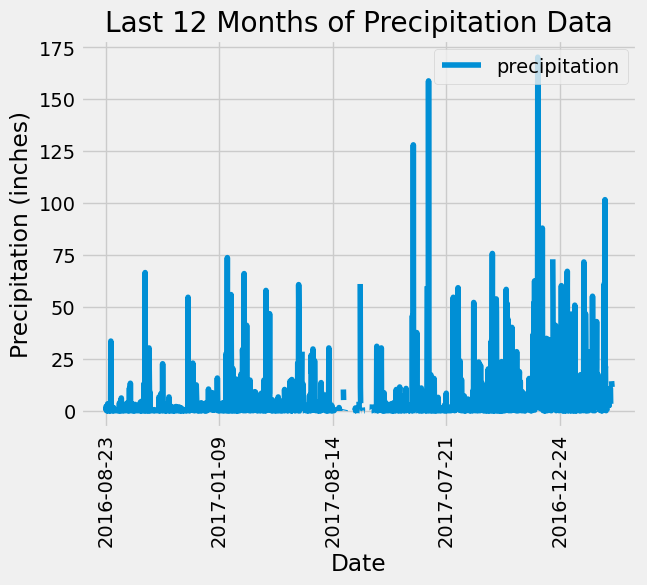

In [10]:

# Get the most recent date from the Measurement table
most_recent_date = session.query(func.max(Measurement.date)).first()

# Convert the most_recent_date to a datetime object
most_recent_date = dt.date(2017,8,23)

# Calculate the date 12 months ago from the most recent date in the database
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Query the precipitation data for the last 12 months
precipitation_data = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date >= one_year_ago)\
    .all()
    #.filter(Measurement.date <= most_recent_date)\
    #.all()

# Store the results in a pandas DataFrame
df_precipitation = pd.DataFrame(precipitation_data, columns=['most_recent_date', 'precipitation'])


# Sort the DataFrame by date
df_precipitation.sort_index(ascending=True, inplace=True)

# Plot the precipitation data
plt.figure(figsize=(10, 6))
#plt.bar(df_precipitation.index, df_precipitation['precipitation'], width=9, label='Precipitation')
df_precipitation.plot(x='most_recent_date',y='precipitation', rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation Data')

plt.legend(loc='upper right')

plt.show()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
# Calculate summary statistics for the precipitation data
summary_statistics = df_precipitation['precipitation'].describe()

# Print the summary statistics
summary_statistics



count    2021.000000
mean        4.505888
std        11.713487
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
# Query to calculate the total number of stations
total_stations = session.query(func.count(Station.station)).scalar()

# Print the total number of stations
print("Total number of stations:", total_stations)


Total number of stations: 9


In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
# Query to find the most active stations and their counts
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                         .group_by(Measurement.station)\
                         .order_by(func.count(Measurement.station).desc())\
                         .all()

# Print the list of most active stations and their counts
for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")



Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Query to calculate the lowest, highest, and average temperature for the most active station
most_active_station_id = active_stations[0][0]
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs))\
                            .filter(Measurement.station == most_active_station_id)\
                            .first()

# Unpack the result tuple
lowest_temp, highest_temp, avg_temp = temperature_stats

# Print the temperature statistics
print(f"Most Active Station: {most_active_station_id}")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")



Most Active Station: USC00519281
Lowest Temperature: 12.2°F
Highest Temperature: 29.4°F
Average Temperature: 22.04°F


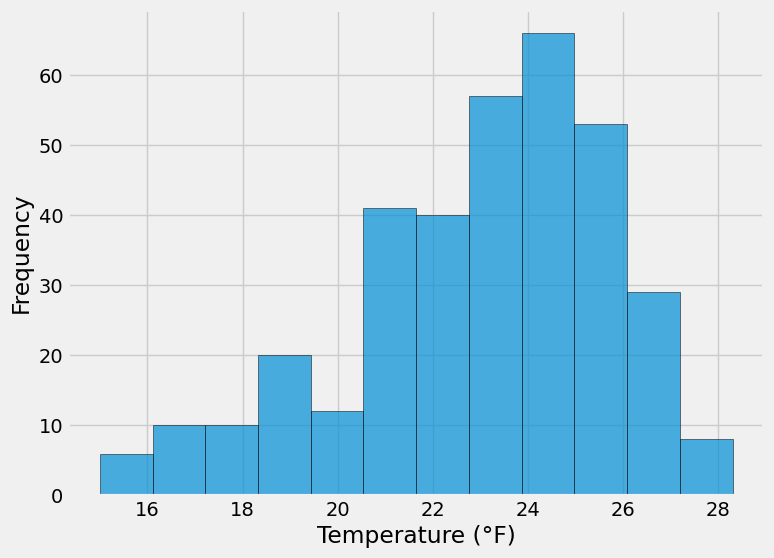

In [16]:
# Calculate the date 12 months ago from the most recent date
one_year_ago_most_active = most_recent_date - dt.timedelta(days=365)

# Query the temperature observation data for the most active station within the last 12 months
temperature_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station_id)\
    .filter(Measurement.date >= one_year_ago_most_active)\
    .all()

# Store the results in a pandas DataFrame
df_temperature = pd.DataFrame(temperature_data, columns=['temperature'])

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(df_temperature['temperature'], bins=12, edgecolor='black', alpha=0.7)
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# Close Session

In [37]:
# Close Session
session.close()